In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

from jax import jit, value_and_grad
import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

In [8]:
import pandas as pd
import numpy as np
import os
import pickle
from pathlib import Path
import re
def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data
# Debug function to log paths and data states
def debug_print(message, variable=None):
    if variable is not None:
        print(f"[DEBUG] {message}: {variable}")
    else:
        print(f"[DEBUG] {message}")

# Function to validate pickle files
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

# Extract last number from a string
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

# def read_jax_file(file_path, gate_name):
#     with open(file_path, 'rb') as f:
#         df = pickle.load(f)
#         df = clean_array(df)
#         costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
#         grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

#         fidelity =df['avg_fidelity'][0]
#         num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
#         try:
#             test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
#         except KeyError:
            
#             test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
#         num_epochs = df['epochs'][0]
#         return costs, fidelity, num_params, test_results,grads_per_epoch


def read_jax_file(file_path):
    """Read and parse the JAX pickle file."""
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)

        costs = np.asarray(df['costs'][0], dtype=np.float64)
        grads_per_epoch = [np.asarray(grad, dtype=np.float64) for grad in df['grads_per_epoch'][0]]
        fidelity = df['avg_fidelity'][0]
        total_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        try:
            test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
        except KeyError:
            
            test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        bath_params = {
            'gamma_scale': df['gamma_scale'][0],
            'lambda_scale': df['lambda_scale'][0],
            'bath_factor': df['bath_factor'][0]
        }

        return costs, fidelity, total_params, test_results, grads_per_epoch, bath_params
# Main extraction loop
N_ctrls = [2]
train_sizes = {2: 20}
num_epochs = 1000
optimal_min_error = 1e-9
optimal_jitter_scale = 1e-10
base_path = './digital_results_trainable_baths/'
rows = []
selected_bath_factors = [1.0]
selected_gamma_scales =[0.01]
selected_lambda_scales =  [0.1]

for N_ctrl in N_ctrls:
    training_size = train_sizes[N_ctrl]
    training_folder = f'trainsize_{training_size}_epoch{num_epochs}'

    for bath_factor in selected_bath_factors:
        bath_folder_path = os.path.join(base_path, training_folder, f'bath_factor_{bath_factor}')
        if not os.path.exists(bath_folder_path):
            continue

        gamma_folders = sorted(
            [d for d in os.listdir(bath_folder_path) if d.startswith('gamma_') and float(d.split('_')[1]) in selected_gamma_scales]
        )

        for gamma_folder in gamma_folders:
            lambda_folders = sorted(
                [d for d in os.listdir(os.path.join(bath_folder_path, gamma_folder)) if d.startswith('lambda_') and float(d.split('_')[1]) in selected_lambda_scales]
            )

            for lambda_folder in lambda_folders:
                folder_path = os.path.join(bath_folder_path, gamma_folder, lambda_folder)

                for num_bath in range(3):  # Assuming baths are numbered as 0, 1, 2
                    bath_folder = os.path.join(folder_path, f'{num_bath}_num_baths/')

                    # Check if the bath folder exists for num_bath
                    if not os.path.exists(bath_folder):
                        print(f"[WARNING] Bath folder for num_bath={num_bath} does not exist: {bath_folder}")
                        continue

                    has_data = False  # Track if there is data for this bath

                    for gate_folder in sorted(os.listdir(bath_folder)):
                        if gate_folder.startswith(f'U{N_ctrl}_'):
                            gate_path = os.path.join(bath_folder, gate_folder)

                            for reservoir_folder in sorted(os.listdir(gate_path), key=extract_last_number):
                                if 'reservoirs_' in reservoir_folder:
                                    reservoir_count = extract_last_number(reservoir_folder)
                                    reservoir_path = os.path.join(gate_path, reservoir_folder)

                                    for trot_folder in sorted(os.listdir(reservoir_path), key=extract_last_number):
                                        if 'trotter_step_' in trot_folder:
                                            trotter_step = extract_last_number(trot_folder)
                                            trotter_path = os.path.join(reservoir_path, trot_folder)

                                            files_in_folder = os.listdir(trotter_path)
                                            current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                            current_best_data_point = None
                                            num_data_runs = 0

                                            for file in files_in_folder:
                                                if not file.startswith('.') and file.endswith('.pickle'):
                                                    pickle_file = os.path.join(trotter_path, file)

                                                    if is_valid_pickle_file(Path(pickle_file)):
                                                          # Data exists for this bath
                                                        costs, fidelity, total_params, test_results, grads_per_epoch, bath_params = read_jax_file(pickle_file)
                                                        num_data_runs += 1  # Increment the number of data runs
                                                        run = os.path.basename(pickle_file).replace('.pickle', '')

                                                        if fidelity > current_best_fidelity:
                                                            has_data = True
                                                            current_best_fidelity = fidelity
                                                            fidelities, infidelities, log_infidelities = [], [], []
                                                            for i, fidelity in enumerate(test_results):
                                                                fidelity = np.clip(fidelity, 0.0, 1.0)  # Ensure fidelity is within [0, 1]
                                                                infidelity = 1.0 - fidelity
                                                                if infidelity <= 0:
                                                                    # Numerical error, apply clipping with dynamically determined values
                                                                    jitter = np.random.uniform(-optimal_jitter_scale, optimal_jitter_scale)
                                                                    infidelity = optimal_min_error + jitter
                                                                    assert infidelity > 0, f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {optimal_jitter_scale}."
                                                                    fidelity = 1.0 - infidelity

                                                                fidelities.append(fidelity)
                                                                infidelities.append(infidelity)
                                                                log_infidelities.append(np.log10(infidelity))

                                                            avg_fidelity = np.mean(fidelities)
                                                            avg_infidelity = np.mean(infidelities)
                                                            std_fidelity = np.std(fidelities)

                                                            if num_bath == 0:
                                                                bath_params['gamma_scale'] = float(gamma_folder.split('_')[1])
                                                                bath_params['lambda_scale'] = float(lambda_folder.split('_')[1])

                                                            current_best_data_point = {
                                                                'N_C': N_ctrl,
                                                                'Gate': gate_folder,
                                                                'Bath_Factor': bath_factor,
                                                                'Bath': num_bath,
                                                                'Reservoirs': reservoir_count,
                                                                'Trotter_Step': trotter_step,
                                                                'Avg_Fidelity': avg_fidelity,
                                                                'Std_Fidelity': std_fidelity,
                                                                'Avg_Infidelity': avg_infidelity,
                                                                'Var_Infidelity': np.var(infidelities),
                                                                'Costs': costs,
                                                                'Infidelities': infidelities,
                                                                'fidelities': fidelities,
                                                                'Param_Count': total_params,
                                                                'Run': run,
                                                                'Error_Test_Results': log_infidelities,
                                                                'Bath_Params': bath_params,
                                                                'gamma_scale': float(gamma_folder.split('_')[1]),
                                                                'lambda_scale': float(lambda_folder.split('_')[1])
                                                            }


                                            if current_best_data_point:
                                                rows.append(current_best_data_point)

                    if not has_data and num_bath == 0:
                        print(f"[ERROR] No data found for num_bath={num_bath} in path: {bath_folder}")

# Create a DataFrame from rows
all_data_df = pd.DataFrame(rows)

Unique combinations of gamma_scale and lambda_scale: [(0.01, 0.1)]
Subset for Bath = 0 exists in the data being plotted.


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_71450/3303204867.py:118: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


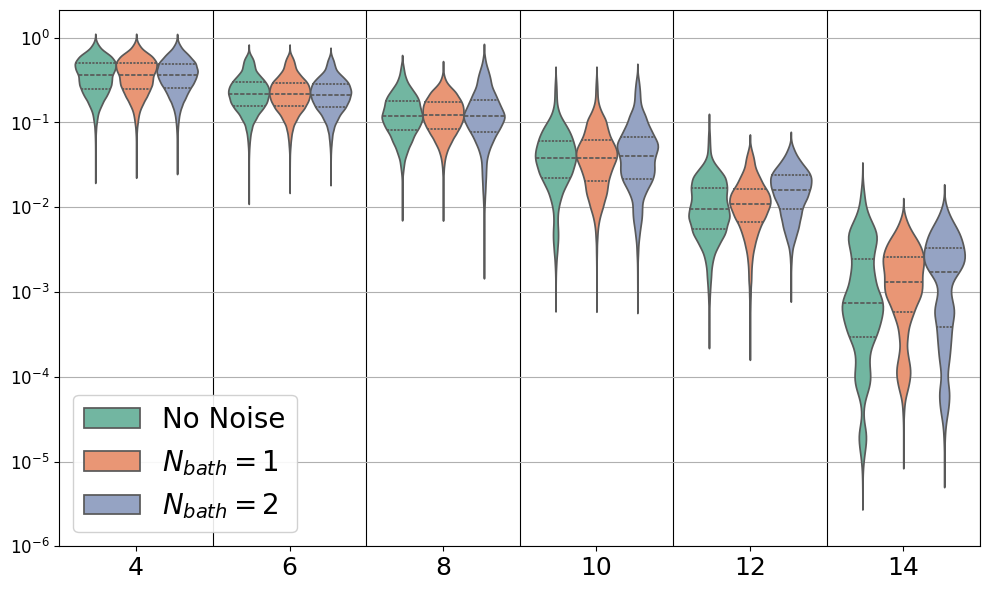

In [14]:
def plot_infidelity_by_scales(data_df, N_C=1, trotter_steps=None, bath_factors=None, gamma_scales=None, lambda_scales=None):
    """
    Plot infidelity (log scale) for specific combinations of bath_factors, gamma_scales, and lambda_scales,
    including the case for no noise (N_bath = 0).

    Args:
        data_df (DataFrame): The DataFrame containing extracted data.
        N_C (int): The number of control qubits to filter the data by.
        trotter_steps (list): A list of specific trotter steps to filter and plot. If None, all steps are used.
        bath_factors (list): List of bath factors to filter data by. If None, all are used.
        gamma_scales (list): List of gamma scales to filter data by. If None, all are used.
        lambda_scales (list): List of lambda scales to filter data by. If None, all are used.
    """
    # Filter data by N_C
    data_Nc = data_df[data_df['N_C'] == N_C]

    # Filter by trotter_steps
    if trotter_steps:
        data_Nc = data_Nc[data_Nc['Trotter_Step'].isin(trotter_steps)]

    # Filter by bath_factors (if necessary)
    if bath_factors:
        data_Nc = data_Nc[data_Nc['Bath_Factor'].isin(bath_factors)]

    if gamma_scales:
        data_Nc = data_Nc[data_Nc['gamma_scale'].isin(gamma_scales)]
        # print(f"Data after filtering by gamma_scales={gamma_scales}:")
        # print(data_Nc[['N_C', 'Bath', 'Trotter_Step', 'gamma_scale', 'lambda_scale']].drop_duplicates())


    # Filter by lambda_scales
    if lambda_scales:
        data_Nc = data_Nc[data_Nc['lambda_scale'].isin(lambda_scales)]

    # Get unique combinations of gamma_scale and lambda_scale
    # Get unique combinations of gamma_scale and lambda_scale
    unique_combinations = data_Nc.groupby(['gamma_scale', 'lambda_scale']).size().index.tolist()
    print(f"Unique combinations of gamma_scale and lambda_scale: {unique_combinations}")

    # Create subplots for each unique combination
    nrows = len(unique_combinations)
    # fig, axes = plt.subplots(
    #     nrows=nrows, figsize=(8, 4 * nrows), sharex=True, sharey=True, constrained_layout=True
    # )
    fig, axes = plt.subplots(
        nrows=nrows, figsize=(10, 6 * nrows), sharey=True, constrained_layout=True
    )

    # Ensure axes is always iterable
    if nrows == 1:
        axes = [axes]

    # Iterate over each unique combination and plot
    for ax, (gamma_scale, lambda_scale) in zip(axes, unique_combinations):
        df_to_plot = data_Nc[
            (data_Nc['gamma_scale'] == gamma_scale) & (data_Nc['lambda_scale'] == lambda_scale)
        ]

        all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
        all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

        # Ensure the Bath column includes "No Noise" (N_bath = 0)
        all_test_results['Bath'] = all_test_results['Bath'].fillna(0).astype(int)

        # Add vertical strips of color for trotter steps
        unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
        positions = range(1, len(unique_trotter_steps) + 1)
        for i, pos in enumerate(positions):
            ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)
        # Check if the subset of data passed to the plotting function contains Bath = 0
        subset = all_test_results[all_test_results['Bath'] == 0]
        if subset.empty:
            print("Subset for Bath = 0 is empty!")
        else:
            print("Subset for Bath = 0 exists in the data being plotted.")
        sns.violinplot(
            x='Trotter_Step',
            y='Log(Infidelity)',
            hue='Bath',
            data=all_test_results,
            ax=ax,
            density_norm='width',
            palette='Set2',
            inner="quart",
            zorder=2
        )

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
        ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.9)

        # Customize grid and title
        ax.yaxis.grid(True, zorder=1)
        ax.xaxis.grid(False)

        # ax.set_title(
        #     f'$\\gamma_{{scale}} = {gamma_scale}, \\lambda_{{scale}} = {lambda_scale}$ Non-Markovian Noise (digital)',
        #     fontsize=20
        # )
        ax.set_xlabel(None)
        ax.set_ylabel(None)

        # Adjust Y-ticks for log scale
        y_ticks = ax.get_yticks()
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)

        ax.set_yticks(whole_y_ticks)
        ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Adjust tick sizes
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.show()

# Example call
plot_infidelity_by_scales(
    all_data_df,
    N_C=2,
    trotter_steps=[4,6,8,10,12,14],
    bath_factors=[1.0],
    gamma_scales=[0.01,0.1],
    lambda_scales=[0.01, 0.1]
)

In [ ]:
def plot_infidelity_by_scales(data_df, N_C=1, trotter_steps=None, bath_factors=None, gamma_scales=None, lambda_scales=None):
    """
    Plot infidelity (log scale) for specific combinations of bath_factors, gamma_scales, and lambda_scales,
    including the case for no noise (N_bath = 0).

    Args:
        data_df (DataFrame): The DataFrame containing extracted data.
        N_C (int): The number of control qubits to filter the data by.
        trotter_steps (list): A list of specific trotter steps to filter and plot. If None, all steps are used.
        bath_factors (list): List of bath factors to filter data by. If None, all are used.
        gamma_scales (list): List of gamma scales to filter data by. If None, all are used.
        lambda_scales (list): List of lambda scales to filter data by. If None, all are used.
    """
    # Filter data by N_C
    data_Nc = data_df[data_df['N_C'] == N_C]

    # Filter by trotter_steps
    if trotter_steps:
        data_Nc = data_Nc[data_Nc['Trotter_Step'].isin(trotter_steps)]

    # Filter by bath_factors (if necessary)
    if bath_factors:
        data_Nc = data_Nc[data_Nc['Bath_Factor'].isin(bath_factors)]

    if gamma_scales:
        data_Nc = data_Nc[data_Nc['gamma_scale'].isin(gamma_scales)]
        # print(f"Data after filtering by gamma_scales={gamma_scales}:")
        # print(data_Nc[['N_C', 'Bath', 'Trotter_Step', 'gamma_scale', 'lambda_scale']].drop_duplicates())


    # Filter by lambda_scales
    if lambda_scales:
        data_Nc = data_Nc[data_Nc['lambda_scale'].isin(lambda_scales)]

    # Get unique combinations of gamma_scale and lambda_scale
    # Get unique combinations of gamma_scale and lambda_scale
    unique_combinations = data_Nc.groupby(['gamma_scale', 'lambda_scale']).size().index.tolist()
    print(f"Unique combinations of gamma_scale and lambda_scale: {unique_combinations}")

    # Create subplots for each unique combination
    nrows = len(unique_combinations)
    # fig, axes = plt.subplots(
    #     nrows=nrows, figsize=(8, 4 * nrows), sharex=True, sharey=True, constrained_layout=True
    # )
    fig, axes = plt.subplots(
        nrows=nrows, figsize=(8, 4 * nrows), sharey=True, constrained_layout=True
    )

    # Ensure axes is always iterable
    if nrows == 1:
        axes = [axes]

    # Iterate over each unique combination and plot
    for ax, (gamma_scale, lambda_scale) in zip(axes, unique_combinations):
        df_to_plot = data_Nc[
            (data_Nc['gamma_scale'] == gamma_scale) & (data_Nc['lambda_scale'] == lambda_scale)
        ]

        all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
        all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

        # Ensure the Bath column includes "No Noise" (N_bath = 0)
        all_test_results['Bath'] = all_test_results['Bath'].fillna(0).astype(int)

        # Add vertical strips of color for trotter steps
        unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
        positions = range(1, len(unique_trotter_steps) + 1)
        for i, pos in enumerate(positions):
            ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)
        # Check if the subset of data passed to the plotting function contains Bath = 0
        subset = all_test_results[all_test_results['Bath'] == 0]
        if subset.empty:
            print("Subset for Bath = 0 is empty!")
        else:
            print("Subset for Bath = 0 exists in the data being plotted.")
        sns.violinplot(
            x='Trotter_Step',
            y='Log(Infidelity)',
            hue='Bath',
            data=all_test_results,
            ax=ax,
            density_norm='width',
            palette='Set2',
            inner="quart",
            zorder=2
        )

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
        ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

        # Customize grid and title
        ax.yaxis.grid(True, zorder=1)
        ax.xaxis.grid(False)

        ax.set_title(
            f'$\\gamma_{{scale}} = {gamma_scale}, \\lambda_{{scale}} = {lambda_scale}$ Non-Markovian Noise (digital model)',
            fontsize=15
        )
        ax.set_xlabel('$N_{trots}$', fontsize=22)
        ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

        # Adjust Y-ticks for log scale
        y_ticks = ax.get_yticks()
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)

        ax.set_yticks(whole_y_ticks)
        ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Adjust tick sizes
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.show()

# Example call
plot_infidelity_by_scales(
    all_data_df,
    N_C=1,
    trotter_steps=[1,2,3],
    bath_factors=[1.0],
    gamma_scales=[0.1],
    lambda_scales=[0.01, 0.1]
)

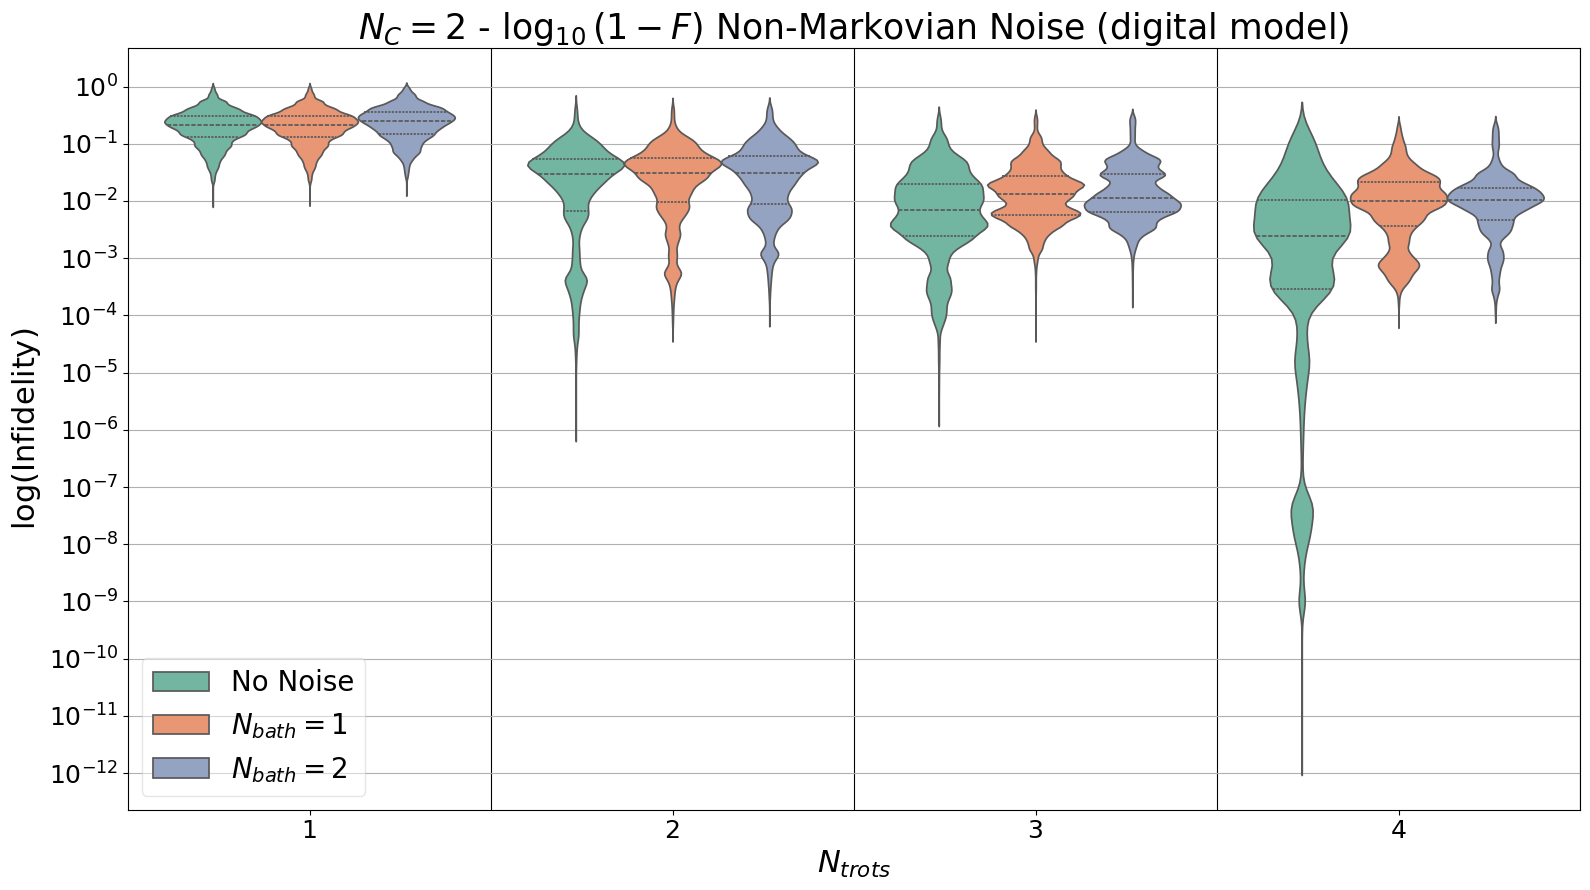

In [15]:
# data_Nc_1 = all_data_df[all_data_df['N_C'] == 1]
data_Nc_2 = all_data_df[all_data_df['N_C'] == 2]
df_to_plot = data_Nc_2
selected_trots = [1,2,3,4]
# df_to_plot = df_to_plot[df_to_plot['Trotter_Step'].isin([selected_trots])]
df_to_plot = df_to_plot[df_to_plot['Trotter_Step'] <= 4]
# Create a violin plot based on the new DataFrame
fig, ax = plt.subplots(figsize=(16, 9))


all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

# Add vertical strips of color
unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)

sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Bath',
    data=all_test_results,
    ax=ax,
    # bw_adjust=0.5,
    density_norm='width',
    palette='Set2',
    inner="quart",
    zorder=2
)


# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
legend = ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

# Customize grid and title
ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

# Adjust Y-ticks for log scale
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick+2, max_tick + 1, 1)

ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick sizes
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()



/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_90633/3291738015.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['Log(Infidelity)'] = np.log10(1 - df_to_plot['Avg_Fidelity'].clip(lower=0, upper=1))


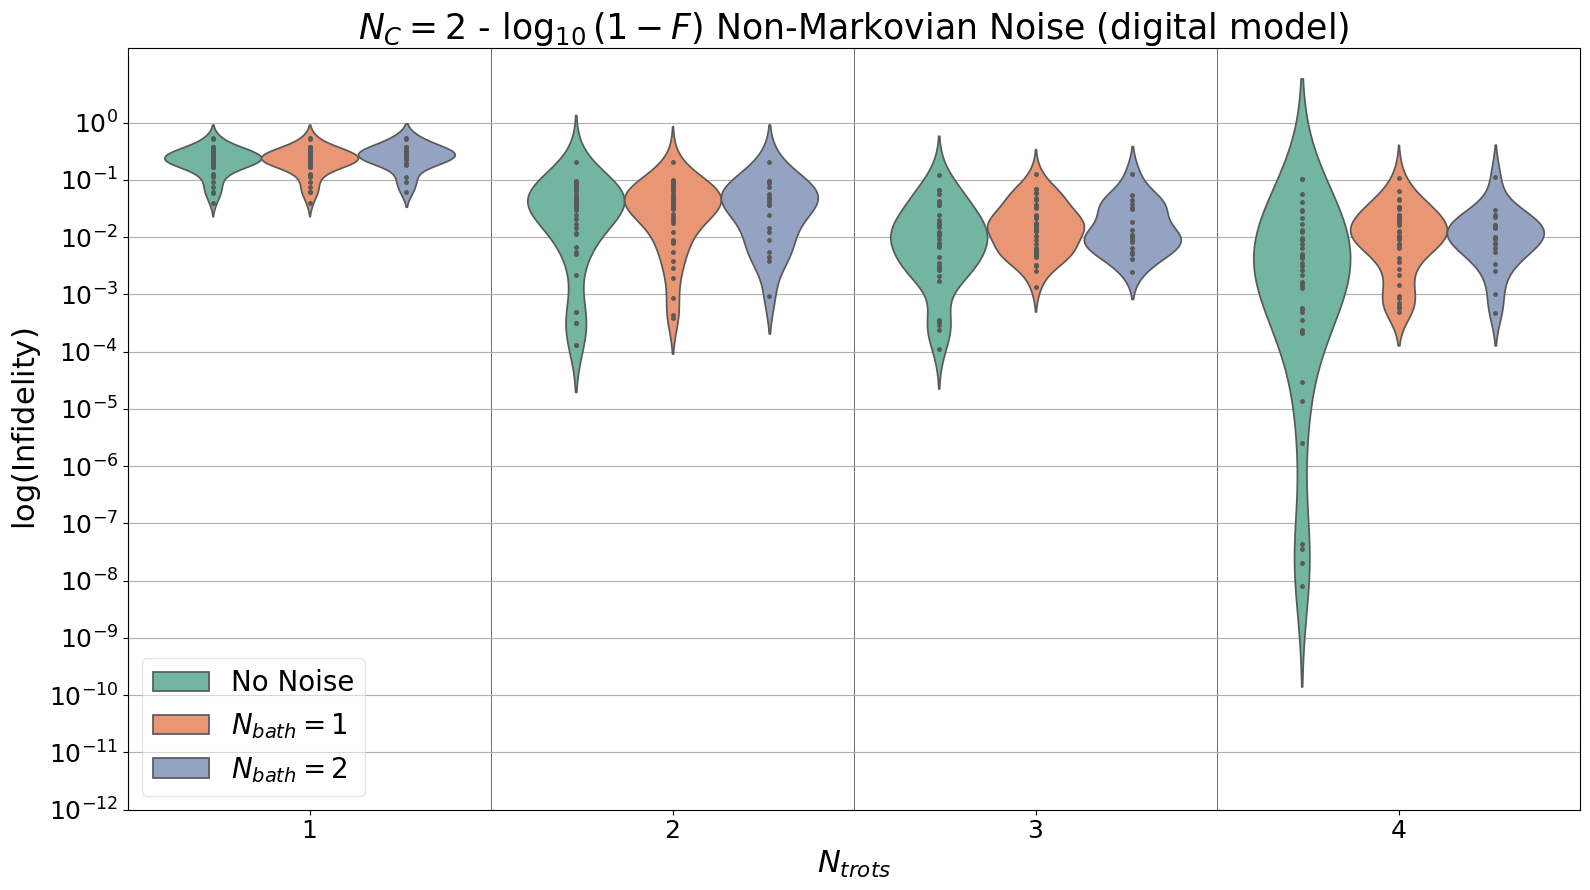

In [16]:

# Create a violin plot based on the new DataFrame
fig, ax = plt.subplots(figsize=(16, 9))
# Prepare data for plotting
df_to_plot['Log(Infidelity)'] = np.log10(1 - df_to_plot['Avg_Fidelity'].clip(lower=0, upper=1))
df_violin = df_to_plot[['Trotter_Step', 'Bath', 'Log(Infidelity)']].rename(columns={'Bath': 'Num Bath'})



# Add vertical strips of color
unique_trotter_steps = sorted(df_to_plot['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.4, zorder=0)
    # if i % 2 == 0:  # Add strip for every other trotter step
    #     ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot average Test Results
sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Bath',
    data=df_to_plot[['Trotter_Step', 'Bath', 'Log(Infidelity)']],
    ax=ax,
    # bw_adjust=0.5,

    density_norm='width',
    palette='Set2',
    inner="point",
    zorder=2
)



# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
legend = ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

# Customize grid and title
ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

# Adjust Y-ticks for log scale
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick sizes
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()

# time dependent

In [4]:
import pandas as pd
import numpy as np
import os
import pickle
from pathlib import Path
import re

def clean_array(data):
    """Helper function to clean any deprecated JAX arrays."""
    if isinstance(data, np.ndarray):
        return np.array(data)  # Ensure the array doesn't have deprecated attributes
    elif isinstance(data, dict):
        return {k: clean_array(v) for k, v in data.items()}
    elif isinstance(data, list):
        return [clean_array(v) for v in data]
    else:
        return data

def debug_print(message, variable=None):
    """Debug function to log paths and data states."""
    if variable is not None:
        print(f"[DEBUG] {message}: {variable}")
    else:
        print(f"[DEBUG] {message}")

def is_valid_pickle_file(file_path):
    """Function to validate pickle files."""
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

def extract_last_number(text):
    """Extract last number from a string."""
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path):
    """Read and parse the JAX pickle file."""
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        df = clean_array(df)

        costs = np.asarray(df['costs'][0], dtype=np.float64)
        grads_per_epoch = [np.asarray(grad, dtype=np.float64) for grad in df['grads_per_epoch'][0]]
        fidelity = df['avg_fidelity'][0]
        total_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        test_results = np.asarray(df['testing_results'][0], dtype=np.float64)
        bath_params = {
            'gamma_scale': df['gamma_scale'][0],
            'lambda_scale': df['lambda_scale'][0],
            'bath_factor': df['bath_factor'][0]
        }

        return costs, fidelity, total_params, test_results, grads_per_epoch, bath_params

# Main extraction loop
N_ctrls = [1]
train_sizes = {1: 10}
num_epochs = 1000
optimal_min_error = 1e-9
optimal_jitter_scale = 1e-10
base_path = './digital_results_trainable_baths/'
rows = []
# Main extraction loop
N_ctrls = [2]
train_sizes = {2: 20}
num_epochs = 1000
optimal_min_error = 1e-9
optimal_jitter_scale = 1e-10
base_path = './digital_results_trainable_baths/'
rows = []

# User-specified filters
selected_bath_factors = [1.0]
selected_gamma_scales = [0.1]
selected_lambda_scales = [0.01, 0.1, 1.0]

for N_ctrl in N_ctrls:
    training_size = train_sizes[N_ctrl]
    training_folder = f'trainsize_{training_size}_epoch{num_epochs}_time_dependent'

    for bath_factor in selected_bath_factors:
        bath_folder_path = os.path.join(base_path, training_folder, f'bath_factor_{bath_factor}')
        if not os.path.exists(bath_folder_path):
            continue

        gamma_folders = sorted(
            [d for d in os.listdir(bath_folder_path) if d.startswith('gamma_') and float(d.split('_')[1]) in selected_gamma_scales]
        )

        for gamma_folder in gamma_folders:
            lambda_folders = sorted(
                [d for d in os.listdir(os.path.join(bath_folder_path, gamma_folder)) if d.startswith('lambda_') and float(d.split('_')[1]) in selected_lambda_scales]
            )

            for lambda_folder in lambda_folders:
                folder_path = os.path.join(bath_folder_path, gamma_folder, lambda_folder)

                for num_bath in range(3):  # Assuming baths are numbered as 0, 1, 2
                    bath_folder = os.path.join(folder_path, f'{num_bath}_num_baths/')

                    # Check if the bath folder exists for num_bath
                    if not os.path.exists(bath_folder):
                        print(f"[WARNING] Bath folder for num_bath={num_bath} does not exist: {bath_folder}")
                        continue

                    for gate_folder in sorted(os.listdir(bath_folder)):
                        if gate_folder.startswith(f'U{N_ctrl}_'):
                            gate_path = os.path.join(bath_folder, gate_folder)

                            for reservoir_folder in sorted(os.listdir(gate_path), key=extract_last_number):
                                if 'reservoirs_' in reservoir_folder:
                                    reservoir_count = extract_last_number(reservoir_folder)
                                    reservoir_path = os.path.join(gate_path, reservoir_folder)

                                    for trot_folder in sorted(os.listdir(reservoir_path), key=extract_last_number):
                                        if 'trotter_step_' in trot_folder:
                                            trotter_step = extract_last_number(trot_folder)
                                            trotter_path = os.path.join(reservoir_path, trot_folder)

                                            files_in_folder = os.listdir(trotter_path)
                                            current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                            current_best_data_point = None

                                            for file in files_in_folder:
                                                if not file.startswith('.') and file.endswith('.pickle'):
                                                    pickle_file = os.path.join(trotter_path, file)

                                                    if is_valid_pickle_file(Path(pickle_file)):
                                                        costs, fidelity, total_params, test_results, grads_per_epoch, bath_params = read_jax_file(pickle_file)
                                                        fidelities, infidelities, log_infidelities = [], [], []

                                                        for i, fidelity in enumerate(test_results):
                                                            fidelity = np.clip(fidelity, 0.0, 1.0)  # Ensure fidelity is within [0, 1]
                                                            infidelity = 1.0 - fidelity
                                                            if infidelity <= 0:
                                                                # Numerical error, apply clipping with dynamically determined values
                                                                jitter = np.random.uniform(-optimal_jitter_scale, optimal_jitter_scale)
                                                                infidelity = optimal_min_error + jitter
                                                                assert infidelity > 0, f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {optimal_jitter_scale}."
                                                                fidelity = 1.0 - infidelity

                                                            fidelities.append(fidelity)
                                                            infidelities.append(infidelity)
                                                            log_infidelities.append(np.log10(infidelity))

                                                        avg_fidelity = np.mean(fidelities)
                                                        avg_infidelity = np.mean(infidelities)
                                                        std_fidelity = np.std(fidelities)

                                                        current_best_data_point = {
                                                            'N_C': N_ctrl,
                                                            'Bath_Factor': bath_factor,
                                                            'Bath': num_bath,
                                                            'Reservoirs': reservoir_count,
                                                            'Trotter_Step': trotter_step,
                                                            'Gate': gate_folder,
                                                            'Avg_Fidelity': avg_fidelity,
                                                            'Std_Fidelity': std_fidelity,
                                                            'Avg_Infidelity': avg_infidelity,
                                                            'Var_Infidelity': np.var(infidelities),
                                                            'Costs': costs,
                                                            'Infidelities': infidelities,
                                                            'fidelities': fidelities,
                                                            'Param_Count': total_params,
                                                            'Run': os.path.basename(pickle_file).replace('.pickle', ''),
                                                            'Error_Test_Results': log_infidelities,
                                                            'Bath_Params': bath_params,
                                                            'gamma_scale': float(gamma_folder.split('_')[1]),
                                                            'lambda_scale': float(lambda_folder.split('_')[1])
                                                        }

                                            if current_best_data_point:
                                                rows.append(current_best_data_point)

# Create a DataFrame from rows
all_data_df = pd.DataFrame(rows)

Unique combinations of gamma_scale and lambda_scale: [(0.1, 0.01), (0.1, 0.1), (0.1, 1.0)]


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_15594/591103651.py:95: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


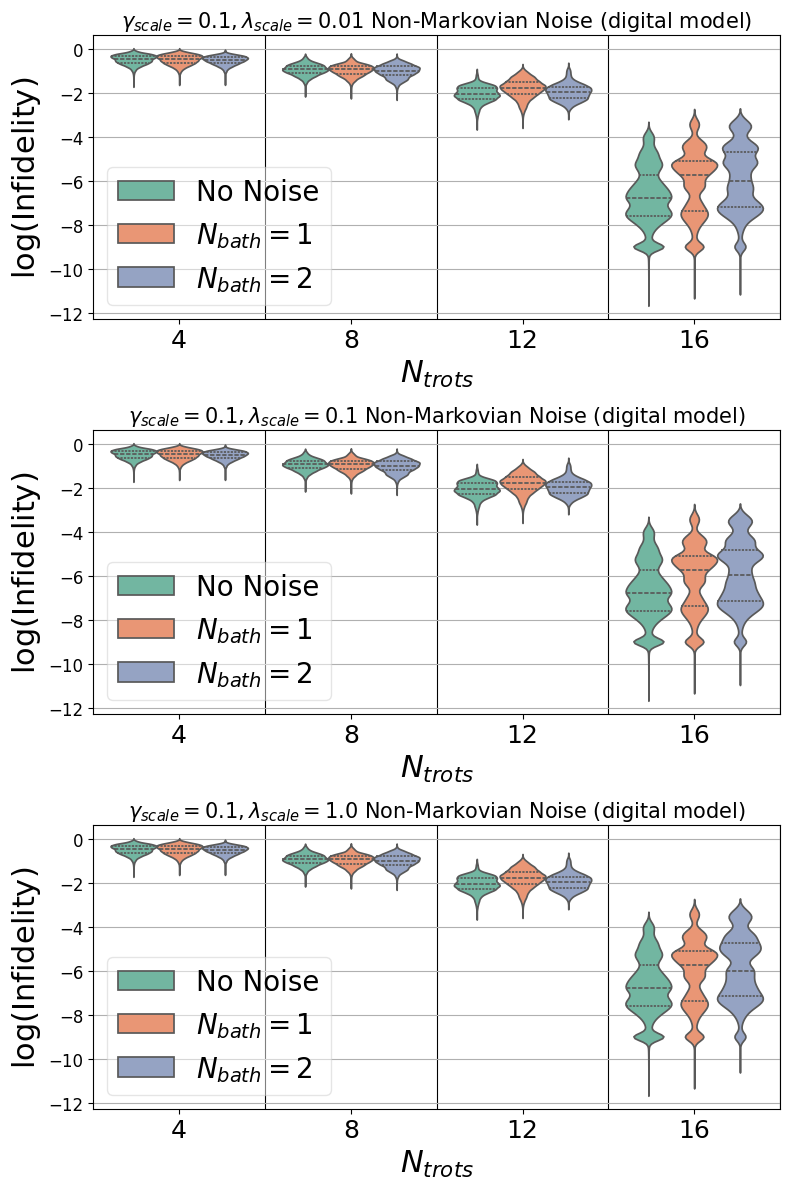

In [5]:
def plot_infidelity_by_scales(data_df, N_C=1, trotter_steps=None, bath_factors=None, gamma_scales=None, lambda_scales=None):
    """
    Plot infidelity (log scale) for specific combinations of bath_factors, gamma_scales, and lambda_scales,
    handling cases where results are deduplicated for num_bath == 0 or num_bath == 1.

    Args:
        data_df (DataFrame): The DataFrame containing extracted data.
        N_C (int): The number of control qubits to filter the data by.
        trotter_steps (list): A list of specific trotter steps to filter and plot. If None, all steps are used.
        bath_factors (list): List of bath factors to filter data by. If None, all are used.
        gamma_scales (list): List of gamma scales to filter data by. If None, all are used.
        lambda_scales (list): List of lambda scales to filter data by. If None, all are used.
    """
    # Filter data by N_C
    data_Nc = data_df[data_df['N_C'] == N_C]

    # Filter by trotter_steps
    if trotter_steps:
        data_Nc = data_Nc[data_Nc['Trotter_Step'].isin(trotter_steps)]

    # Filter by bath_factors
    if bath_factors:
        data_Nc = data_Nc[data_Nc['Bath_Factor'].isin(bath_factors)]

    # Filter by gamma_scales
    if gamma_scales:
        data_Nc = data_Nc[data_Nc['gamma_scale'].isin(gamma_scales)]

    # Filter by lambda_scales
    if lambda_scales:
        data_Nc = data_Nc[data_Nc['lambda_scale'].isin(lambda_scales)]
        # data_Nc = data_Nc[(data_Nc['Bath'] > 1) | (data_Nc['lambda_scale'].isin(lambda_scales))]

    # Group data by gamma_scale and lambda_scale
    unique_combinations = data_Nc.groupby(['gamma_scale', 'lambda_scale']).size().index.tolist()
    print(f"Unique combinations of gamma_scale and lambda_scale: {unique_combinations}")

    # Create subplots for each unique combination
    nrows = len(unique_combinations)
    fig, axes = plt.subplots(
        nrows=nrows, figsize=(8, 4 * nrows), sharey=True, constrained_layout=True
    )

    # Ensure axes is always iterable
    if nrows == 1:
        axes = [axes]

    # Iterate over each unique combination and plot
    for ax, (gamma_scale, lambda_scale) in zip(axes, unique_combinations):
        # Filter data for the current combination
        df_to_plot = data_Nc[
            (data_Nc['gamma_scale'] == gamma_scale) & (data_Nc['lambda_scale'] == lambda_scale)
        ]
        
        # Explode the Error_Test_Results for violin plot
        all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
        all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']
        unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
        positions = range(1, len(unique_trotter_steps) + 1)
        for i, pos in enumerate(positions):
            ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)

        sns.violinplot(
            x='Trotter_Step',
            y='Log(Infidelity)',
            hue='Bath',
            data=all_test_results,
            ax=ax,
            density_norm='width',
            palette='Set2',
            inner="quart",
            zorder=2
        )

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
        ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

        # Customize grid and title
        ax.yaxis.grid(True, zorder=1)
        ax.xaxis.grid(False)

        ax.set_title(
            f'$\\gamma_{{scale}} = {gamma_scale}, \\lambda_{{scale}} = {lambda_scale}$ Non-Markovian Noise (digital model)',
            fontsize=15
        )
        ax.set_xlabel('$N_{trots}$', fontsize=22)
        ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

        # Adjust tick sizes
        ax.tick_params(axis='y', labelsize=12)
        ax.tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.show()

# Example call
plot_infidelity_by_scales(
    all_data_df,
    N_C=2,
    trotter_steps=[4, 8, 12, 16],
    bath_factors=[1.0],
    gamma_scales=[0.1],
    lambda_scales=[0.01, 0.1,1.0]
)

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_90633/3524680231.py:87: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


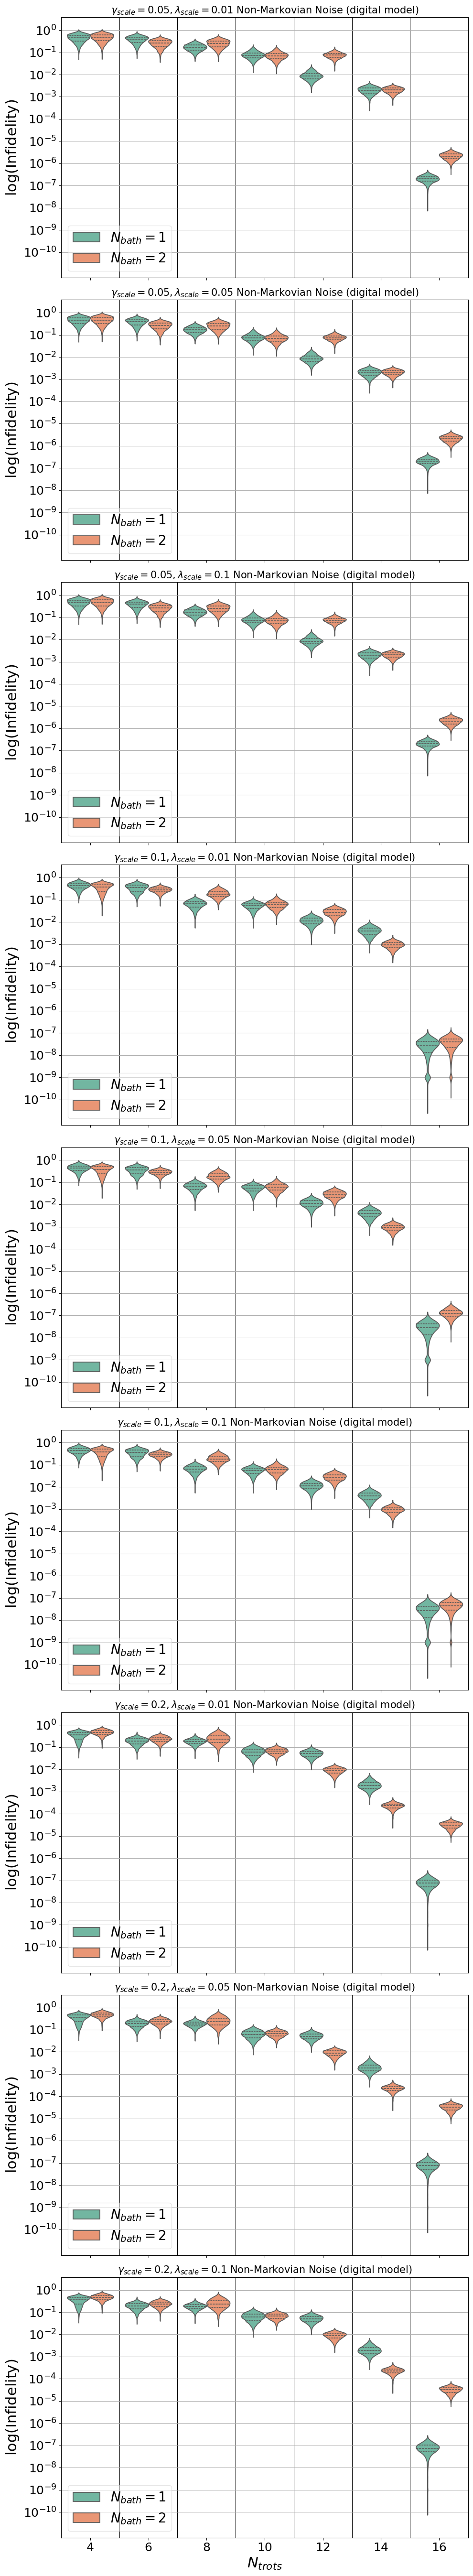

In [ ]:
def plot_infidelity_by_scales(data_df, N_C=1, trotter_steps=None):
    """
    Plot infidelity (log scale) for different combinations of gamma_scale and lambda_scale.

    Args:
        data_df (DataFrame): The DataFrame containing extracted data.
        N_C (int): The number of control qubits to filter the data by.
        trotter_steps (list): A list of specific trotter steps to filter and plot. If None, all steps are used.
    """
    # Filter data for the specific number of control qubits
    data_Nc = data_df[data_df['N_C'] == N_C]
    
    # Filter by specified trotter steps if provided
    if trotter_steps is not None:
        data_Nc = data_Nc[data_Nc['Trotter_Step'].isin(trotter_steps)]

    # Get unique combinations of gamma_scale and lambda_scale
    unique_combinations = data_Nc.groupby(['gamma_scale', 'lambda_scale']).size().index.tolist()

    # Create subplots for each unique combination
    nrows = len(unique_combinations)
    fig, axes = plt.subplots(
        nrows=nrows, figsize=(10, 6 * nrows), sharex=True, sharey=True, constrained_layout=True
    )

    # Ensure axes is always iterable
    if nrows == 1:
        axes = [axes]

    # Iterate over each unique combination and plot
    for ax, (gamma_scale, lambda_scale) in zip(axes, unique_combinations):
        df_to_plot = data_Nc[
            (data_Nc['gamma_scale'] == gamma_scale) & (data_Nc['lambda_scale'] == lambda_scale)
        ]

        all_test_results = df_to_plot.explode('Error_Test_Results').reset_index()
        all_test_results['Log(Infidelity)'] = all_test_results['Error_Test_Results']

        # Add vertical strips of color for trotter steps
        unique_trotter_steps = sorted(all_test_results['Trotter_Step'].unique())
        positions = range(1, len(unique_trotter_steps) + 1)
        for i, pos in enumerate(positions):
            ax.axvline(x=pos - 0.5, color='black', linestyle='-', linewidth=0.8, zorder=0)

        sns.violinplot(
            x='Trotter_Step',
            y='Log(Infidelity)',
            hue='Bath',
            data=all_test_results,
            ax=ax,
            density_norm='width',
            palette='Set2',
            inner="quart",
            zorder=2
        )

        # Customize legend
        handles, labels = ax.get_legend_handles_labels()
        new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
        ax.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=20, fancybox=True, framealpha=0.5)

        # Customize grid and title
        ax.yaxis.grid(True, zorder=1)
        ax.xaxis.grid(False)

        ax.set_title(
            f'$\\gamma_{{scale}} = {gamma_scale}, \\lambda_{{scale}} = {lambda_scale}$ Non-Markovian Noise (digital model)',
            fontsize=15
        )
        ax.set_xlabel('$N_{trots}$', fontsize=22)
        ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)

        # Adjust Y-ticks for log scale
        y_ticks = ax.get_yticks()
        whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
        min_tick = min(whole_y_ticks)
        max_tick = max(whole_y_ticks)
        whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)

        ax.set_yticks(whole_y_ticks)
        ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

        # Adjust tick sizes
        ax.tick_params(axis='y', labelsize=18)
        ax.tick_params(axis='x', labelsize=18)

    plt.tight_layout()
    plt.show()


# Example call with specific trotter steps
plot_infidelity_by_scales(all_data_df, N_C=2,  trotter_steps=[4, 8, 12,16])

In [78]:

# Prepare data for plotting
df_to_plot['Log(Infidelity)'] = np.log10(1 - df_to_plot['Avg_Fidelity'].clip(lower=0, upper=1))
all_test_results = df_to_plot.explode('Test_Results').reset_index()
all_test_results['Log(Infidelity)'] = np.log10(1 - np.clip(1 - all_test_results['Test_Results'], 0, 1))

# Plot
fig, ax = plt.subplots(2, 1, figsize=(16, 18), sharex=True)

# Plot all individual Test Results
sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Bath',
    data=all_test_results,
    ax=ax[0],
    bw_adjust=0.5,
    density_norm='width',
    palette='plasma',
    inner="box",
    zorder=2
)
ax[0].set_title('All Data Points: Individual Test Results', fontsize=22)

# Plot average Test Results
sns.violinplot(
    x='Trotter_Step',
    y='Log(Infidelity)',
    hue='Bath',
    data=df_to_plot[['Trotter_Step', 'Bath', 'Log(Infidelity)']],
    ax=ax[1],
    bw_adjust=0.5,
    density_norm='width',
    palette='plasma',
    inner="box",
    zorder=2
)
ax[1].set_title('Averaged Data Points: Per Gate Average Test Results', fontsize=22)

# Add legends, labels, and titles
for ax_i in ax:
    handles, labels = ax_i.get_legend_handles_labels()
    new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
    ax_i.legend(handles, new_labels, title_fontsize=16, loc='lower left', fontsize=16, fancybox=True, framealpha=0.5)
    ax_i.yaxis.grid(True, zorder=1)
    ax_i.xaxis.grid(False)
    ax_i.set_xlabel('$N_{trots}$', fontsize=18)
    ax_i.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=18)

# Adjust Y-ticks for log scale
y_ticks = ax[0].get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)

for ax_i in ax:
    ax_i.set_yticks(whole_y_ticks)
    ax_i.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])
    ax_i.tick_params(axis='y', labelsize=16)
    ax_i.tick_params(axis='x', labelsize=16)

plt.tight_layout()
plt.show()
# /digital_results_trainable_global/trainsize_20_epoch1500_bath_factor_0.1/0_num_baths/)U2_7/reservoirs_3/trotter_step_18//bath_False/data_run_0.pickle

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_10115/1458850009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_plot['Log(Infidelity)'] = np.log10(1 - df_to_plot['Avg_Fidelity'].clip(lower=0, upper=1))


TypeError: loop of ufunc does not support argument 0 of type float which has no callable log10 method

In [59]:
from matplotlib.collections import PathCollection
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

# Define a custom colormap to enhance visual differentiation
width = 0.6  # Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
base_colormap = plt.cm.plasma  # Base colormap for visual appeal
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}

trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['infidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)

# Calculate IQR and prepare violin plot data
violin_plot_data = []

for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        if len(infidelities) > 0:
            # Compute IQR for the infidelities
            q1 = np.percentile(infidelities, 25)  # 25th percentile
            q3 = np.percentile(infidelities, 75)  # 75th percentile
            iqr_values = [x for x in infidelities if q1 <= x <= q3]  # Filter data within IQR
            
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data.append((trotter_step, num_bath, log_infidelity))


[-14. -13. -12. -11. -10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.
   0.]


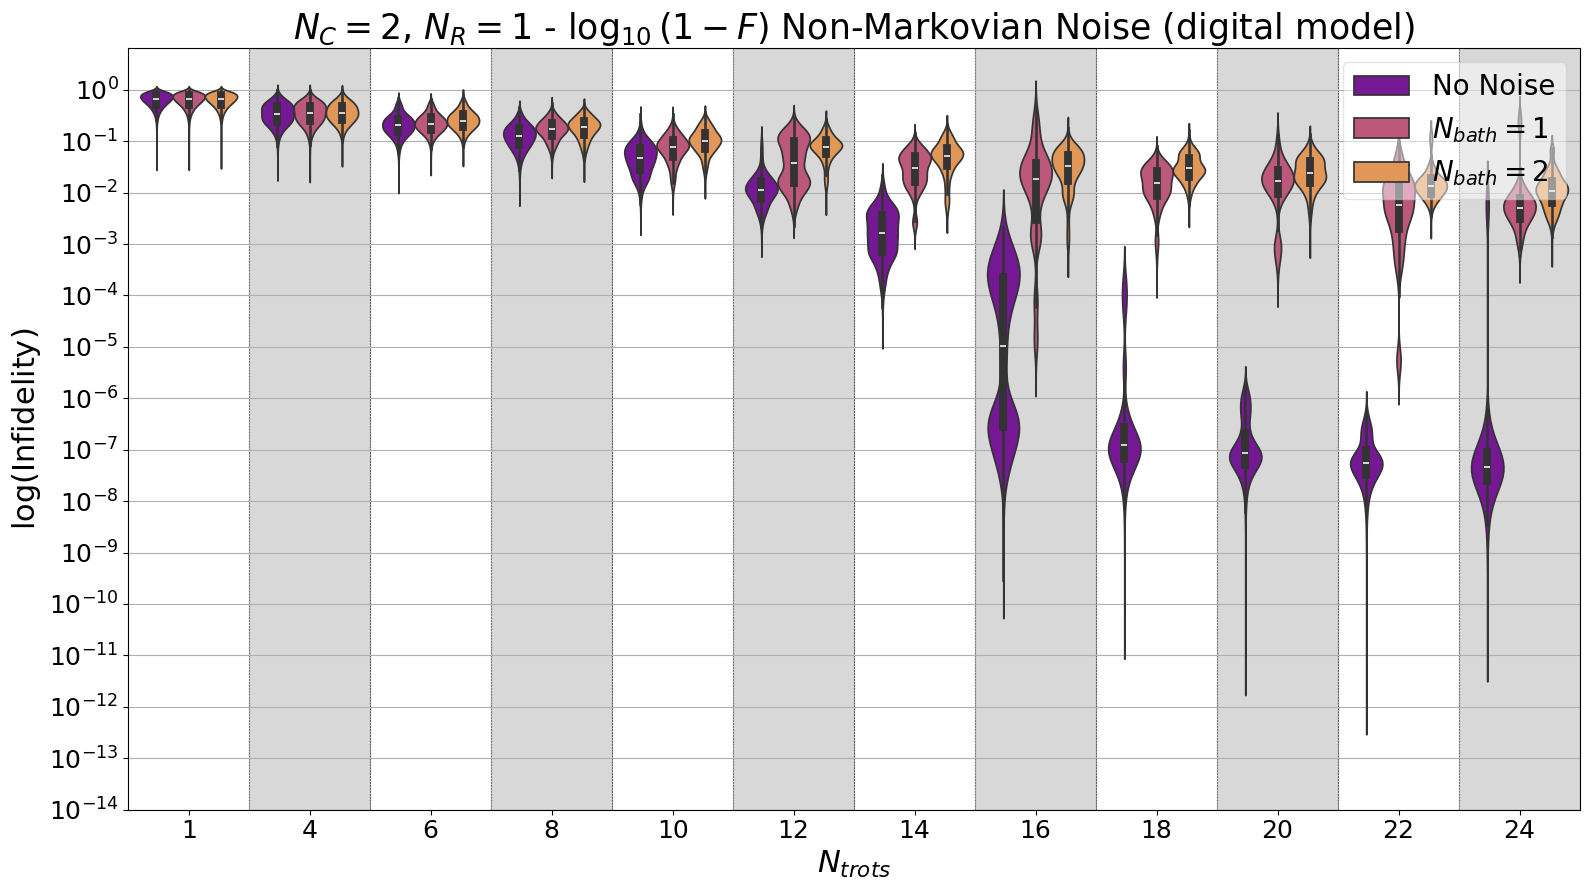

In [60]:
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="box",bw_adjust=2,  hue_order=bath_qubit_counts, zorder=2)


# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)


ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

# # Set Y-ticks and labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
print(whole_y_ticks)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()



[DEBUG] Fidelity Data: {6: {'0': [0.7711181549901517, 0.7966563265190516, 0.7973594482679557, 0.6330459232135232, 0.6798824689111649, 0.8717672532533199, 0.8088504817632354, 0.7557181652938539, 0.8386048282057146, 0.7927779409213476, 0.8705342087170664, 0.7736123294959868, 0.795169355837197, 0.5429102175265745, 0.7844255097413361, 0.8103388582639802, 0.7838528949943049, 0.8036423516751467, 0.5778445934891395, 0.7641243895768643, 0.9351943907581873, 0.6241935848571278, 0.8901988588353204, 0.7622030899803818, 0.6057506133227962, 0.7949455699695192, 0.7602611975316539, 0.6052913308311666, 0.6649035512836451, 0.7269244911201137, 0.5737566927493635, 0.8268226413317549, 0.7109026242576599, 0.8970263341803375, 0.8296378534294611, 0.7848923822484899], '1': [0.7711181552417921, 0.7966563266421376, 0.7973594483269565, 0.6330387447203061, 0.6798824688847649, 0.8717792483443805, 0.8088504816222566, 0.7557181647089078, 0.8386048281168492, 0.7927779410410493, 0.8705331859918853, 0.7736123295450487, 

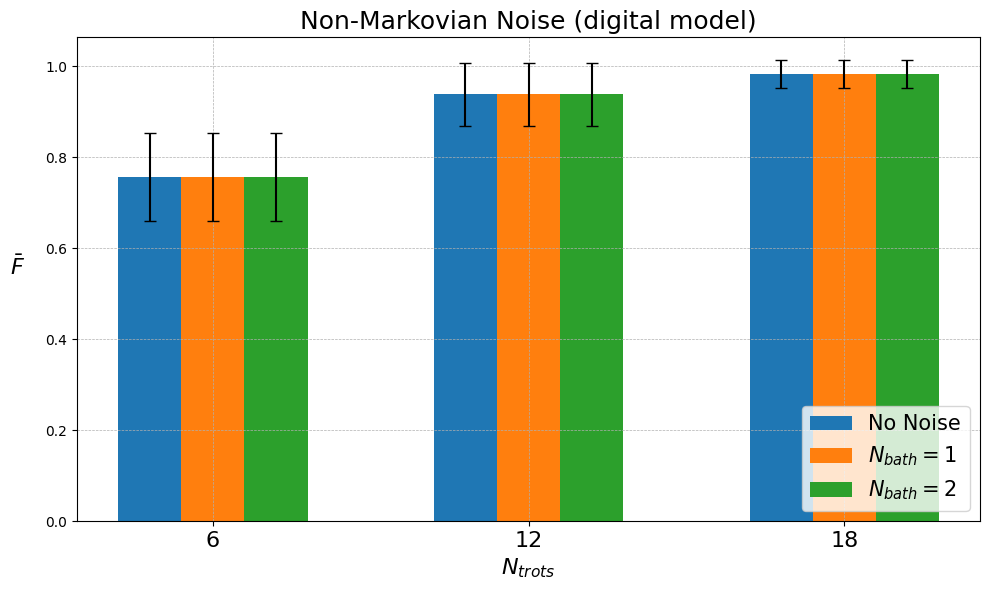

In [25]:

# Prepare data for plotting
fidelity_data = {}
trotter_steps = set()
infidelity_data = {}
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    trotter_steps.add(trotter_step)
                    fidelity = data_point['infidelity']
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)

# Debugging fidelity data
debug_print("Fidelity Data", fidelity_data)

# Calculate averages and standard deviations
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

debug_print("Averaged Data", averaged_data)
debug_print("Standard Deviation Data", standard_deviation_data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
positions = np.arange(len(trots))
bar_width = 0.2

for idx, (num_bath, _) in enumerate(data.items()):
    means = [averaged_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [standard_deviation_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center', label=label)

ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', rotation=0, fontsize=16, labelpad=20)
ax.set_title('Non-Markovian Noise (digital model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=16)
ax.legend(loc='lower right', fontsize=15)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [20]:

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
infidelity_data = {}
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count != target_res:
                continue
            
            for trotter_step, data_point in trotter_data.items():
                if trotter_step in trots:
                    test_results = data_point['test_results']
                    test_results = np.clip(test_results, 0, 1)
                    infidelity_res = 1 - np.array(test_results)
                    trotter_steps.add(trotter_step)  # Keep track of trotter steps
                    fidelity = data_point['fidelity']  # Calculate fidelity from infidelity
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                    infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(infidelity_res)
# Create violin plot
fig, ax = plt.subplots(figsize=(16, 9))

violin_plot_data = []
for trotter_step, res_data in infidelity_data.items():
    for num_bath, infidelities in res_data.items():
        for infidelity in infidelities:
            log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
            violin_plot_data.append((trotter_step, num_bath, log_infidelity))

df_violin = pd.DataFrame(violin_plot_data, columns=['Trotter_Step', 'Num Bath', 'Log(Infidelity)'])

# Add vertical strips of color
unique_trotter_steps = sorted(df_violin['Trotter_Step'].unique())
positions = range(1, len(unique_trotter_steps) + 1)
for i, pos in enumerate(positions):
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4, zorder=0)
    if i % 2 == 0:  # Add strip for every other trotter step
        ax.axvspan(pos - 0.5, pos + 0.5, color='grey', alpha=0.3, zorder=0)

# Plot violin plot
sns.violinplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
               palette='plasma', density_norm='width', inner="point", bw_adjust=.75, hue_order=bath_qubit_counts, zorder=2)

# Add stripplot on top of the violin plot
#sns.stripplot(x='Trotter_Step', y='Log(Infidelity)', hue='Num Bath', data=df_violin, ax=ax,
#              palette='plasma', dodge=True, jitter=True, size=4, alpha=0.6, hue_order=bath_qubit_counts, zorder=3, marker='o')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
new_labels = ['No Noise' if int(label) == 0 else f'$N_{{bath}} = {label}$' for label in labels]
new_handles = [handles[0], handles[1], handles[2]]

legend = ax.legend(handles=new_handles, labels=new_labels, title_fontsize=16, loc='upper right', fontsize=20, fancybox=True, framealpha=0.5)

# Adjust z-order of violin plots, strip plots, and legend
for artist in ax.lines:
    artist.set_zorder(10)
for artist in ax.findobj(PathCollection):
    artist.set_zorder(11)

ax.yaxis.grid(True, zorder=1)
ax.xaxis.grid(False)

ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}$ - $\log_{{10}}(1 - F)$ Non-Markovian Noise (digital model)', fontsize=25)
ax.set_xlabel('$N_{trots}$', fontsize=22)
ax.set_ylabel(r'$\log(\text{Infidelity})$', fontsize=22)
y_ticks = ax.get_yticks()

whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

ax.tick_params(axis='y', labelsize=18)
ax.tick_params(axis='x', labelsize=18)

plt.tight_layout()
plt.show()


KeyError: 'fidelity'


DEBUG: log_infidelity_data structure:

DEBUG: Violin plot data:
Positions: []
Violin data length: 0

DEBUG: Colors used in violin plot:
[]


ValueError: zero-size array to reduction operation minimum which has no identity

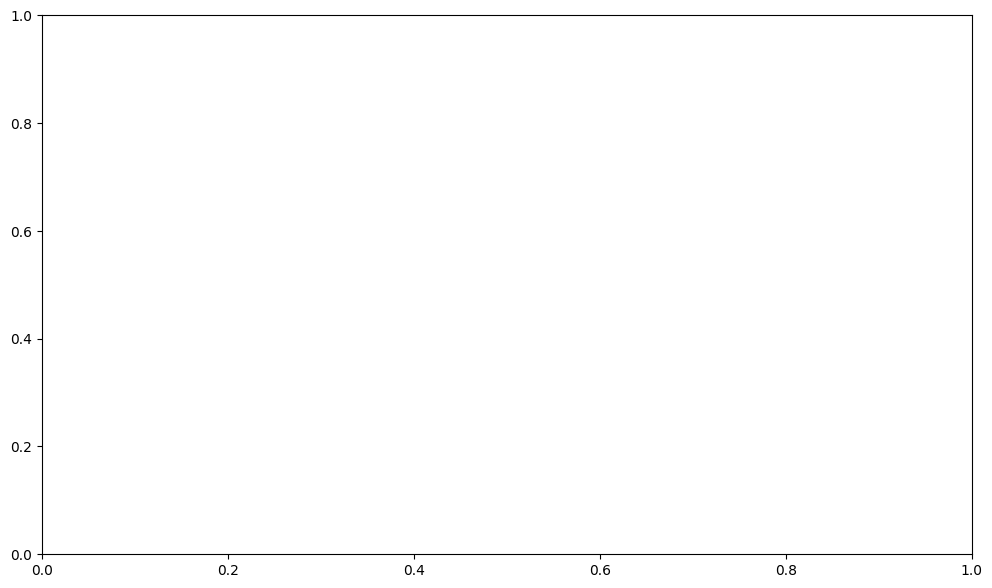

In [12]:
# Prepare data for plotting
log_infidelity_data = {}  # Data structure for storing log10(infidelity) information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1

# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        infidelity = 1 - fidelity  # Convert fidelity to infidelity
                        log_infidelity = np.log10(np.clip(infidelity, 1e-14, 1.0))  # Log10 of infidelity
                        log_infidelity_data.setdefault(num_bath, {}).setdefault(trotter_step, []).append(log_infidelity)

# Debugging: Print the processed log_infidelity_data
print("\nDEBUG: log_infidelity_data structure:")
for num_bath, trotter_dict in log_infidelity_data.items():
    print(f"  N_bath = {num_bath}")
    for trotter_step, log_infidelities in trotter_dict.items():
        print(f"    N_trots = {trotter_step}: {len(log_infidelities)} entries")
        if len(log_infidelities) > 0:
            print(f"      Sample data: {log_infidelities[:5]}")  # Show sample entries

# Create violin plots
fig, ax = plt.subplots(figsize=(12, 7))
positions = []  # To store positions for each violin plot
violin_data = []  # To store the data for each violin
violin_colors = []  # Colors for each violin plot

# Prepare violin plot data
for idx, num_bath in enumerate(sorted(log_infidelity_data.keys(), key=int)):
    for trotter_step in sorted(log_infidelity_data[num_bath].keys()):
        positions.append(trotter_step)
        violin_data.append(log_infidelity_data[num_bath][trotter_step])
        color = 'purple' if int(num_bath) == 0 else 'orange' if int(num_bath) == 2 else 'pink'
        violin_colors.append(color)

# Debugging: Print the violin plot data
print("\nDEBUG: Violin plot data:")
print("Positions:", positions)
print("Violin data length:", len(violin_data))
for idx, data in enumerate(violin_data[:5]):  # Limit output for readability
    print(f"  Data[{idx}] length: {len(data)}")
    if len(data) > 0:
        print(f"    Sample values: {data[:5]}")

print("\nDEBUG: Colors used in violin plot:")
print(violin_colors[:5])  # Print the first few colors for validation

# Create the violin plot
parts = ax.violinplot(violin_data, positions=positions, showmeans=True, showextrema=True, widths=0.8)

# Apply custom colors
for patch, color in zip(parts['bodies'], violin_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_alpha(0.7)

# Customize plot
ax.set_yscale('log')
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\log_{10}(\text{Infidelity})$', fontsize=16)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}: \log_{10}(1-F)$ Non-Markovian Noise (digital model)', fontsize=18)

# Add legend
handles = [
    mpatches.Patch(color='purple', label='No Noise'),
    mpatches.Patch(color='pink', label=r'$N_{\text{bath}} = 1$'),
    mpatches.Patch(color='orange', label=r'$N_{\text{bath}} = 2$'),
]
ax.legend(handles=handles, loc='lower left', fontsize=12)

ax.grid(which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

KeyError: 6

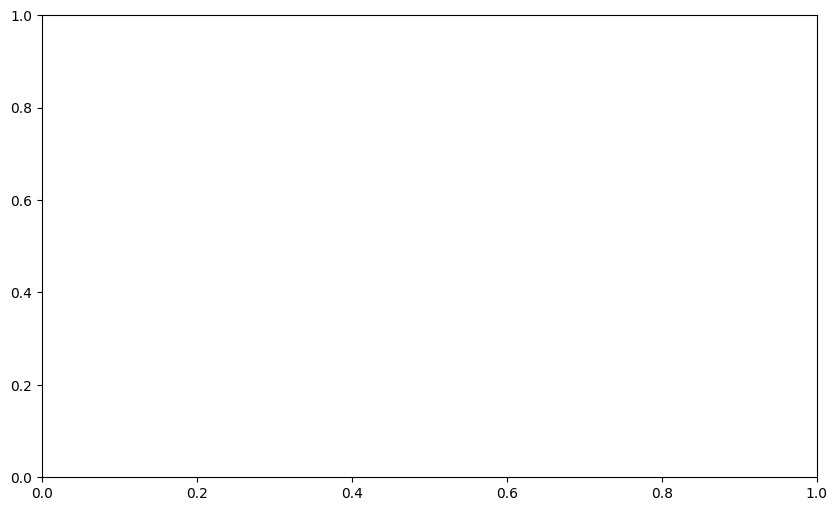

In [7]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import re

def is_valid_pickle_file(file_path):
    """
    Check if the file is a valid pickle file.
    """
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False


def extract_last_number(text):
    """
    Extract the last number from a string.
    """
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0


def read_jax_file(file_path):
    """
    Read relevant data from a JAX pickle file.
    """
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        return df['avg_infidelity'][0], [float(i) for i in df['test_results'][0]]


# Initialize key parameters
N_ctrl = 2
training_size = 20
num_epochs = 1500
bath_factor = 0.1
trots = [6, 12, 18]
target_res = 1
base_path = f'/Users/sophieblock/Downloads/debug/digital_results_trainable_global/trainsize_{training_size}_epoch{num_epochs}_bath_factor_{bath_factor}/'

data = {str(i): {} for i in range(3)}  # Initialize for no noise, N_bath = 1, and N_bath = 2

# Process data
for bath_idx, num_bath in enumerate(data.keys()):
    bath_data = data[num_bath]
    ctrl_path = os.path.join(base_path, f"{num_bath}_num_baths/")

    for folder_name in sorted(os.listdir(ctrl_path)):
        if folder_name.startswith(f'U{N_ctrl}_'):
            gate = folder_name
            bath_data[gate] = {}

            gate_path = os.path.join(ctrl_path, gate)
            for subfolder in sorted(os.listdir(gate_path), key=extract_last_number):
                if 'reservoirs_' in subfolder:
                    reservoir_count = extract_last_number(subfolder)

                    subfolder_path = os.path.join(gate_path, subfolder)
                    for trotter_folder in sorted(os.listdir(subfolder_path), key=extract_last_number):
                        if 'trotter_step_' in trotter_folder:
                            trotter_step = extract_last_number(trotter_folder)

                            if bath_idx == 0:
                                trotter_path = os.path.join(subfolder_path, trotter_folder, 'bath_False')
                            else:
                                trotter_path = os.path.join(subfolder_path, trotter_folder)

                            if not os.path.exists(trotter_path):
                                continue

                            for file in os.listdir(trotter_path):
                                pickle_file = os.path.join(trotter_path, file)
                                if is_valid_pickle_file(Path(pickle_file)):
                                    infidelity, test_results = read_jax_file(pickle_file)
                                    if reservoir_count not in bath_data[gate]:
                                        bath_data[gate][reservoir_count] = {}
                                    if trotter_step not in bath_data[gate][reservoir_count]:
                                        bath_data[gate][reservoir_count][trotter_step] = {
                                            'infidelity': infidelity,
                                            'test_results': []
                                        }
                                    bath_data[gate][reservoir_count][trotter_step]['test_results'].extend(test_results)

# Process fidelities for plotting
fidelity_data = {}
averaged_data = {}
std_dev_data = {}
for num_bath, gates in data.items():
    for gate, reservoirs in gates.items():
        for reservoir_count, trotters in reservoirs.items():
            if reservoir_count == target_res:
                for trotter_step, results in trotters.items():
                    fidelity = 1 - results['infidelity']
                    test_results = np.clip(results['test_results'], 0, 1)
                    fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)
                    averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(test_results)
                    std_dev_data.setdefault(trotter_step, {})[num_bath] = np.std(test_results)

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6 / len(data)  # Adjust bar width dynamically
positions = np.arange(len(trots))

for idx, (num_bath, _) in enumerate(data.items()):
    means = [averaged_data[trot].get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [std_dev_data[trot].get(num_bath, 0) for trot in sorted(trots)]
    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'

    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, label=label, zorder=3)

# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', fontsize=16, labelpad=20, rotation=0)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}$: Non-Markovian Noise (Digital Model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=14)
ax.set_ylim([0.2, 1.01])
ax.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

Processed Trotter Steps:
[6, 12, 18]

Available Averaged Data Keys:
dict_keys([])

Processing bath count 0:
Averaged data for bath 0: {}

Processing bath count 1:
Averaged data for bath 1: {}

Processing bath count 2:
Averaged data for bath 2: {}


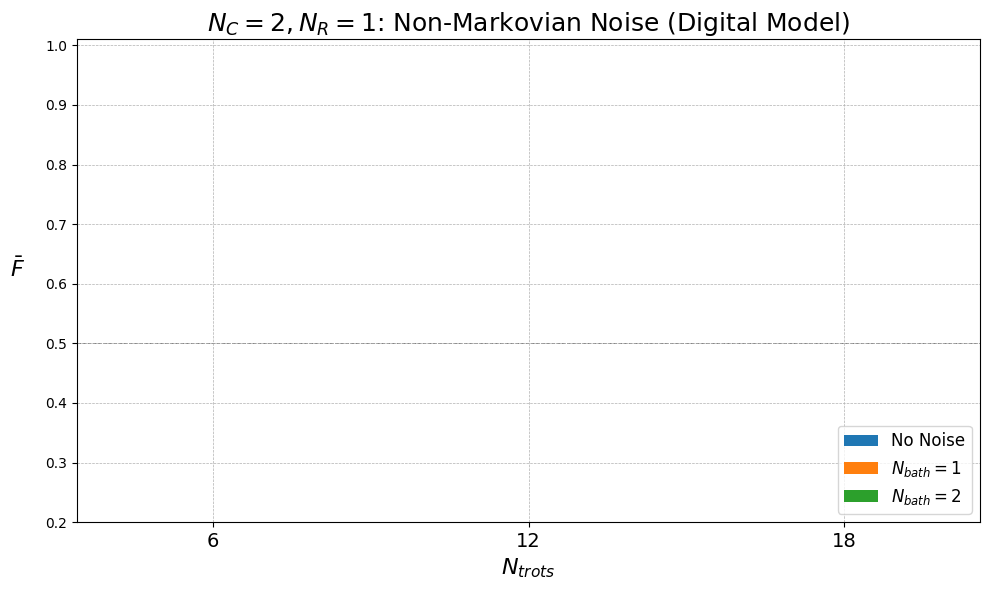

In [8]:
# Debugging: Check processed trotter steps and bath counts
print("Processed Trotter Steps:")
print(sorted(trots))
print("\nAvailable Averaged Data Keys:")
print(averaged_data.keys())

# Plot results
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.6 / len(data)  # Adjust bar width dynamically
positions = np.arange(len(trots))

for idx, (num_bath, _) in enumerate(data.items()):
    # Debugging: Print the data for each num_bath
    print(f"\nProcessing bath count {num_bath}:")
    print(f"Averaged data for bath {num_bath}: {averaged_data}")

    # Safely handle missing trotter steps
    means = [averaged_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]
    std_devs = [std_dev_data.get(trot, {}).get(num_bath, 0) for trot in sorted(trots)]

    label = 'No Noise' if int(num_bath) == 0 else f'$N_{{bath}} = {num_bath}$'

    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, label=label, zorder=3)

# Customize plot
ax.set_xlabel(r'$N_{trots}$', fontsize=16)
ax.set_ylabel(r'$\bar{F}$', fontsize=16, labelpad=20, rotation=0)
ax.set_title(f'$N_C = {N_ctrl}, N_R = {target_res}$: Non-Markovian Noise (Digital Model)', fontsize=18)
ax.set_xticks(positions + bar_width * (len(data) - 1) / 2)
ax.set_xticklabels(sorted(trots), fontsize=14)
ax.set_ylim([0.2, 1.01])
ax.grid(True, linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)
ax.legend(loc='lower right', fontsize=12)

plt.tight_layout()
plt.show()

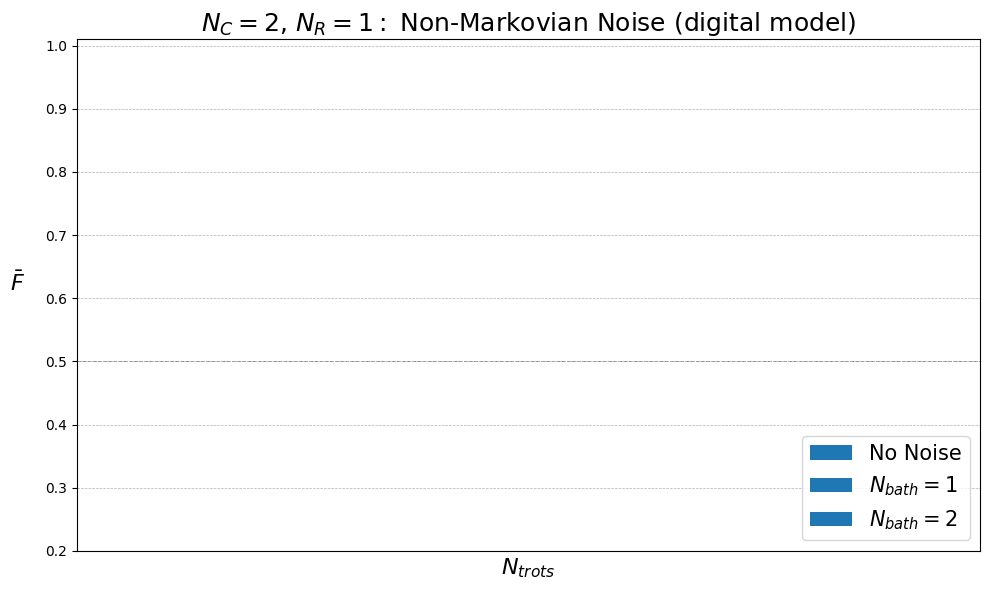

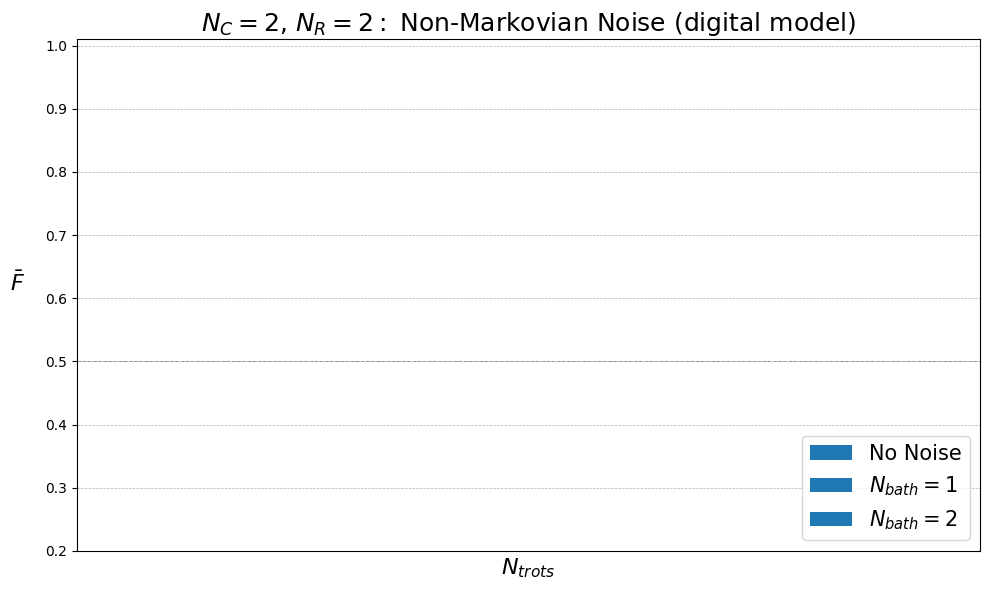

In [4]:
trots = [6,12,18]
# Initialize your plotting parameters
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(bath_qubit_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.plasma  # Base colormap for visual appeal

# Define a custom colormap to enhance visual differentiation
values = np.linspace(0, 1, n_colors)**4  # Modify the distribution of the colormap
colors = base_colormap(values)
custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_plasma', colors, N=n_colors)

# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 1
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()


# Prepare data for plotting
fidelity_data = {}  # Data structure for storing fidelity information
trotter_steps = set()  # Set to keep track of all trotter steps encountered
target_res = 2
infidelity_data = {}
# Extract fidelity data for plotting
for num_bath, gates in data.items():
    for gate, reservoir_data in gates.items():
        for reservoir_count, trotter_data in reservoir_data.items():
            if reservoir_count == target_res:
                
            
                for trotter_step, data_point in trotter_data.items():
                    if trotter_step in trots:
                    
                        trotter_steps.add(trotter_step)  # Keep track of trotter steps
                        fidelity = 1 - data_point['infidelity']  # Calculate fidelity from infidelity
                        fidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).append(fidelity)
                        test_results = data_point['test_results']
                        test_results = np.clip(test_results, 0, 1)  # Ensure values are between 0 and 1

                        # Store infidelities directly
                        infidelity_data.setdefault(trotter_step, {}).setdefault(num_bath, []).extend(test_results)

# Calculate average fidelity and standard deviation for plotting
averaged_data = {}
standard_deviation_data = {}
for trotter_step, bath_data in fidelity_data.items():
    
    for num_bath, fidelities in bath_data.items():
        averaged_data.setdefault(trotter_step, {})[num_bath] = np.mean(fidelities)
        standard_deviation_data.setdefault(trotter_step, {})[num_bath] = np.std(fidelities)

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = width / n_groups
positions = np.array(range(len(trotter_steps)))  # Base positions for each trotter step group


# Plot data
for idx, num_bath in enumerate(bath_qubit_counts):
    means = [averaged_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    std_devs = [standard_deviation_data[ts].get(num_bath, 0) for ts in sorted(trotter_steps)]
    if int(num_bath) == 0:
        label = 'No Noise'
    else:
        label = f'$N_{{bath}} = {num_bath}$'
    ax.bar(positions + idx * bar_width, means, bar_width, yerr=std_devs, capsize=4, align='center',  label=label,zorder=3)

ax.set_xlabel(r'$N_{trots}$',fontsize=16)

ax.set_ylabel(r'$\bar{F}$',rotation=0,fontsize = 16,labelpad=20)
ax.set_title(f'$N_C = {N_ctrl}$, $N_R = {target_res}:$ Non-Markovian Noise (digital model)',fontsize=18)
ax.set_xticks(positions + bar_width * (n_groups - 1) / 2)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0])
ax.set_xticklabels(sorted(trotter_steps),fontsize=16)
ax.legend(loc='lower right',fontsize=15)
ax.grid(zorder=0)
ax.set_ylim([0.2, 1.01])  # Assuming fidelity values range from 0 to 1
ax.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
ax.axhline(y=0.5, color='grey', linestyle='--', linewidth=0.7, zorder=1)

plt.tight_layout()
plt.show()

